# Compare USDM & SPI
a. stein 4.18.2022

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import sedi.wrangle as wrangle

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':


Load in USDM and SPI

In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

# USDM will be already clipped, but we'll need to clip spi real quick
usdm = xr.open_dataset(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc')
spi_1y = xr.open_dataset(f'{dm_path}/spi/spi1y.nc')

In [3]:
usdm_da_wa = usdm['USDM'].rio.write_crs('EPSG:4326', inplace=True)
spi_da = spi_1y['spi'].rio.write_crs('EPSG:4326', inplace=True)

Grab some bounds for Washington and check the crs

In [4]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)
wa_gdf = states_gdf[(states_gdf.NAME=='Washington')]

In [5]:
wa_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Clip SPI to WA

In [6]:
spi_da_wa = wrangle.clip_xarray(spi_da, wa_gdf)

In [7]:
spi_da_wa

<xarray.DataArray 'spi' (day: 3066, lat: 84, lon: 188)>
array([[[        nan,         nan,         nan, ..., -0.6199999 ,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.6199999 ,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -1.28      ,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -0.71000004,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.9000001 ,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -1.28      ,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -0.32000017,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.38999987,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.38999987,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * day      (day) datetime64[ns] 1980-01-05 1980-01-10 ... 2021-12-31
    crs      int64 0
Attributes:
    units:              
    description:        Standardized Precipitation Index
    long_name:          spi1y
    standard_name:      spi1y
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326

In [8]:
usdm_da_wa

<xarray.DataArray 'USDM' (date: 1163, lat: 139, lon: 314)>
[50760298 values with dtype=float64]
Coordinates:
  * lat          (lat) float64 49.0 48.97 48.95 48.92 ... 45.62 45.6 45.57 45.55
  * lon          (lon) float64 -124.7 -124.7 -124.7 ... -117.0 -116.9 -116.9
  * date         (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
    spatial_ref  int64 0
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -124.74590760646159 0.024999999999999963 0....

## Prelim plots

So I know that USDM is every week (7 days), while SPI is every 5 days.

In [9]:
# this is the first time stamp for UDSM ...
usdm_da_wa_sel = usdm_da_wa.sel(date='2000-01-04')

In [10]:
# and it looks like there is an SPI for the 5th, so that's
# close enough for me
spi_da_wa_sel = spi_da_wa.sel(day='2000-01-05')

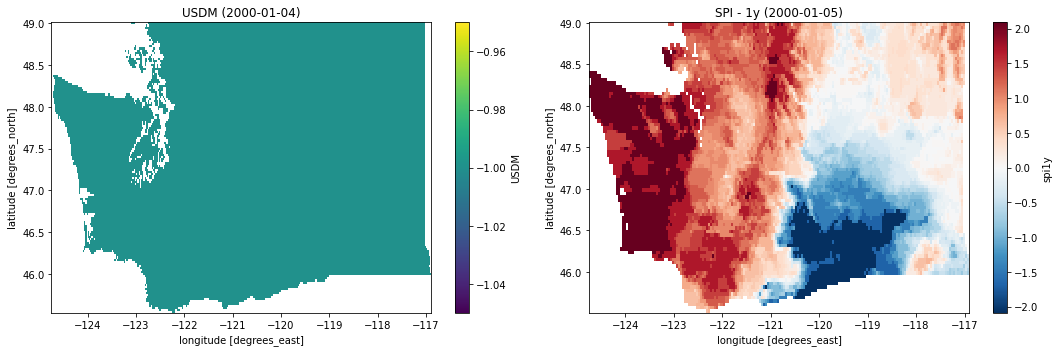

In [11]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

usdm_da_wa_sel.plot(ax=ax[0])
spi_da_wa_sel.plot(ax=ax[1])

ax[0].set_title('USDM (2000-01-04)')
ax[1].set_title('SPI - 1y (2000-01-05)')

plt.tight_layout()

Hm, let's make a function to get the correct USDM colorbar ...

-1 : Neutral (or Wet)    
0 : D0 (Abnormal Dry)    
1 : D1 (Moderate Drought)    
2 : D2 (Severe Drought)    
3 : D3 (Extreme Drought)    
4 : D4 (Exceptional Drought)

In [28]:
usdm_colors=["white","yellow","navajowhite","orange","crimson","darkred"]
usdm_cmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", usdm_colors)
usdm_cats = ["D0","D1","D2","D3","D4"]

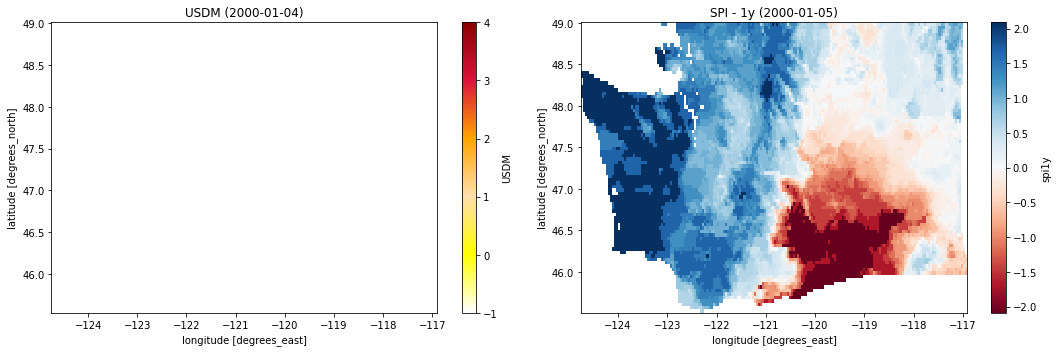

In [64]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

usdm_plot = usdm_da_wa_sel.plot(ax=ax[0], cmap = usdm_cmap, vmin=-1, vmax=4)
spi_da_wa_sel.plot(ax=ax[1], cmap='RdBu')

ax[0].set_title('USDM (2000-01-04)')
ax[1].set_title('SPI - 1y (2000-01-05)')

plt.tight_layout()

That works. It seems a bit tricky to get the proper labels, so I'm going to move on since it'll be useful to preserve those values for operations.

Here is the USDM's breakdown on values for SPI to create like-catagories: https://droughtmonitor.unl.edu/About/AbouttheData/DroughtClassification.aspx

D0 : -0.5 to -0.7 (21 to 30 p)    
D1 : -0.8 to -1.2 (11 to 20 p)    
D2 : -1.3 to -1.5 (6 to 10 p)    
D3 : -1.6 to -1.9 (3 to 5 p)    
D4 : -2.0 or less (0 to 2 p)

Which would then place the -1 marker to be anything greater than -0.5 I think ... yeah because USDM doesn't distinguish between degrees of wetness, so it'd all be the same.

Let's try implementing this ... and if it works then I'll toss it in a function

In [88]:
spi_1y_usdmcat = spi_da_wa_sel.copy()
# need to get the underlying array because I can't do this fancy
# indexing on the datarray (sad)
spi_1y_usdmcat_vals = spi_1y_usdmcat.values
# need to make a copy we don't edit to not compound reassignment
spi_1y_usdmcat_origin = spi_1y_usdmcat_vals.copy()
# set values ...
spi_1y_usdmcat_vals[spi_1y_usdmcat_origin > -0.5] = -1
spi_1y_usdmcat_vals[(spi_1y_usdmcat_origin <= -0.5)&(spi_1y_usdmcat_origin > -0.8)] = 0
spi_1y_usdmcat_vals[(spi_1y_usdmcat_origin <= -0.8)&(spi_1y_usdmcat_origin > -1.3)] = 1
spi_1y_usdmcat_vals[(spi_1y_usdmcat_origin <= -1.3)&(spi_1y_usdmcat_origin > -1.6)] = 2
spi_1y_usdmcat_vals[(spi_1y_usdmcat_origin <= -1.6)&(spi_1y_usdmcat_origin > -2.0)] = 3
spi_1y_usdmcat_vals[(spi_1y_usdmcat_origin <= -2.0)] = 4

In [89]:
spi_1y_usdmcat.loc[:,:] = spi_1y_usdmcat_vals

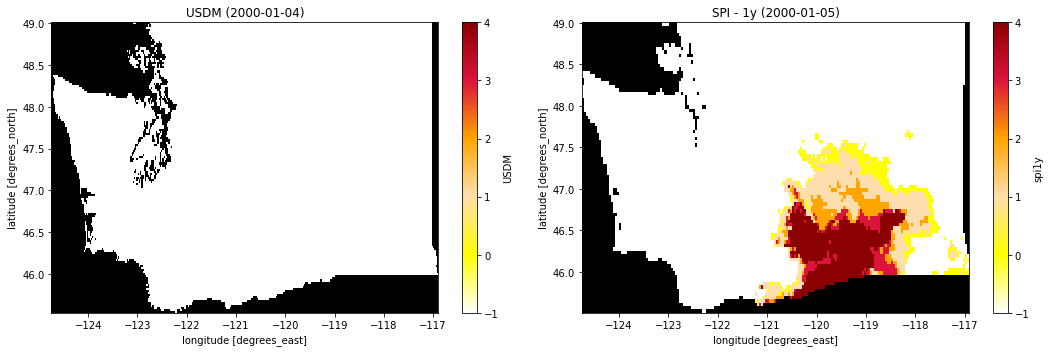

In [98]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

usdm_plot = usdm_da_wa_sel.plot(ax=ax[0], cmap = usdm_cmap, vmin=-1, vmax=4)
spi_1y_usdmcat.plot(ax=ax[1], cmap = usdm_cmap, vmin=-1, vmax=4)

ax[0].set_title('USDM (2000-01-04)')
ax[1].set_title('SPI - 1y (2000-01-05)')

# this will help make sure I'm not missing data ...
ax[0].set_facecolor('k')
ax[1].set_facecolor('k')

plt.tight_layout()

Ayyy, not too bad.

Let's get that in a function

In [102]:
def spi_to_usdmcat(spi_da:xr.DataArray):
    """Categorizes SPI based on USDM categories.

    Uses the mapping scheme presented by USDM (https://droughtmonitor.unl.edu/About/AbouttheData/DroughtClassification.aspx)
    Where Neutral is -1, D0 is 0, D1 is 1, D2, is 2, D3 is 3, and D4 is 4.

    Parameters
    ----------
    spi_da : xr.DataArray
        Contains SPI values.
    
    Returns
    -------
    xr.DataArray
        DataArray formatted the same as spi_da but using USDM categories.

    """

    # make sure we don't overwrite the original
    spi_da_copy = spi_da.copy()
    # can only do boolean indexing on the underlying array
    spi_da_vals = spi_da.values
    # get a copy to make sure reassignment isn't compounding
    spi_da_origin = spi_da_vals.copy()

    # assign neutral
    spi_da_vals[spi_da_origin > -0.5] = -1
    # assign D0
    spi_da_vals[(spi_da_origin <= -0.5)&(spi_da_origin > -0.8)] = 0
    # assign D1
    spi_da_vals[(spi_da_origin <= -0.8)&(spi_da_origin > -1.3)] = 1
    # assign D2
    spi_da_vals[(spi_da_origin <= -1.3)&(spi_da_origin > -1.6)] = 2
    # assign D3
    spi_da_vals[(spi_da_origin <= -1.6)&(spi_da_origin > -2.0)] = 3
    # assign D4
    spi_da_vals[(spi_da_origin <= -2.0)] = 4

    # put them back into the dataarray
    spi_da_copy.loc[:,:] = spi_da_vals

    return spi_da_copy

Test the function ...

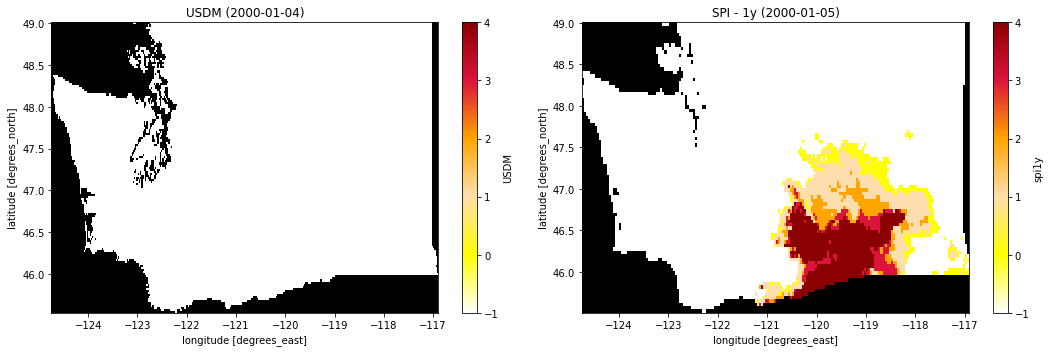

In [101]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

usdm_plot = usdm_da_wa_sel.plot(ax=ax[0], cmap = usdm_cmap, vmin=-1, vmax=4)
spi_to_usdmcat(spi_da_wa_sel).plot(ax=ax[1], cmap = usdm_cmap, vmin=-1, vmax=4)

ax[0].set_title('USDM (2000-01-04)')
ax[1].set_title('SPI - 1y (2000-01-05)')

# this will help make sure I'm not missing data ...
ax[0].set_facecolor('k')
ax[1].set_facecolor('k')

plt.tight_layout()

Great!

Now how do I compare them ... especially since they have different gridding ..